<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# 9.02 Lab: Forecasting 

_Authors: Jeff Hale_

---

Let's practice univariate time series forecasting.

---

#### Data 

The Rossmann stores dataset.


#### Context

You're the new data scientist for Rossman company. 

#### Goal
You manager tasks you with trying to build a model to predict how many customers store 863 will see in future days.
---

#### Explore the data and get it ready for modeling



In [47]:
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
ross = pd.read_csv('./data/rossmann.csv', index_col='Date', parse_dates=True)
ross.head()

/var/folders/p1/89v2vyg94jd0blrmm4w41wr00000gn/T/ipykernel_83381/2001939090.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  ross = pd.read_csv('./data/rossmann.csv', index_col='Date', parse_dates=True)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [3]:
ross.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


#### Filter to store 863

In [14]:
ross = ross[ross['Store']== 863].sort_index()
ross.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,863,2,0,0,0,0,a,1
2013-01-02,863,3,8279,1051,1,0,0,1
2013-01-03,863,4,6732,835,1,0,0,1
2013-01-04,863,5,8341,1029,1,0,0,1
2013-01-05,863,6,5582,666,1,0,0,0


#### If using sktime, the index needs converted to a period

In [18]:
ross.index = ross.index.to_period('D')

#### Set up y
⚠️ Add 1 to the number of customers for each observation so that Holt-Winters will work. Otherwise you will get an error because some values are 0.

In [19]:
y = ross["Customers"] + 1
y

Date
2013-01-01       1
2013-01-02    1052
2013-01-03     836
2013-01-04    1030
2013-01-05     667
              ... 
2015-07-27    1235
2015-07-28    1104
2015-07-29    1076
2015-07-30    1008
2015-07-31    1431
Freq: D, Name: Customers, Length: 942, dtype: int64

In [20]:
y.info()

<class 'pandas.core.series.Series'>
PeriodIndex: 942 entries, 2013-01-01 to 2015-07-31
Freq: D
Series name: Customers
Non-Null Count  Dtype
--------------  -----
942 non-null    int64
dtypes: int64(1)
memory usage: 14.7 KB


#### Split the data into training and test sets. Make the most recent 30 days the test set.

In [22]:
# With help from lesson 9.04
y_train, y_test = temporal_train_test_split(y, test_size=30)

#### Plot the training and test set sales over time.

/Users/andresperez/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/sktime/utils/validation/series.py:274: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


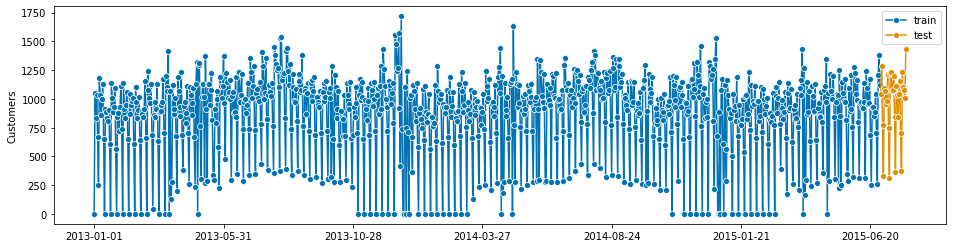

In [24]:
plot_series(y_train, y_test, labels=['train', 'test']);


#### Were those really 0 customers some days? Why else might some observations be 0?

**Holidays and Sundays**

In [28]:
ross[ross["Customers"] == 0].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,863,2,0,0,0,0,a,1
2013-01-13,863,7,0,0,0,0,0,0
2013-01-20,863,7,0,0,0,0,0,0
2013-01-27,863,7,0,0,0,0,0,0
2013-02-03,863,7,0,0,0,0,0,0


## Baseline (naive) models

#### Make a baseline model that is the mean of the training data. 

You can do this manually, or with a library such as sktime.

In [30]:
baseline_mean = NaiveForecaster(strategy='mean')
baseline_mean

NaiveForecaster(strategy='mean')

In [31]:
baseline_mean.fit(y_train)

NaiveForecaster(strategy='mean')

In [32]:
baseline_mean_preds = baseline_mean.predict(y_test.index)

/Users/andresperez/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/sktime/utils/datetime.py:38: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/Users/andresperez/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/sktime/utils/datetime.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
/Users/andresperez/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/sktime/utils/datetime.py:38: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])


#### Plot the predictions on the test set and the actuals for the test set.


/Users/andresperez/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/sktime/utils/validation/series.py:274: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


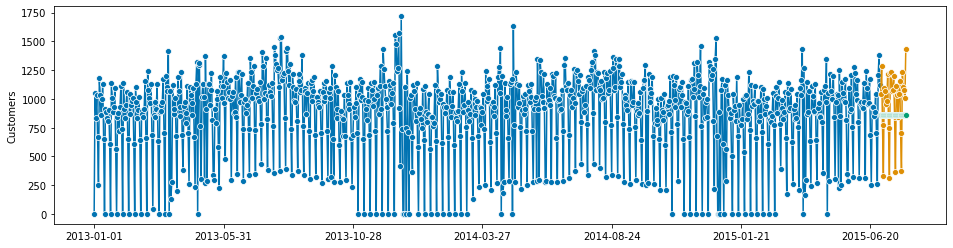

In [33]:
plot_series(y_train, y_test, baseline_mean_preds);

#### Score your mean baseline model on the test set using Mean Absolute Error (MAE).

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
mean_absolute_error(y_test, baseline_mean_preds)

266.5078947368421

#### Make a seasonal baseline model. 

You can do this manually, or with a library such as sktime.

Think carefully about the optimal number of seasonal periods. Try a few different values for the number.

In [46]:
seasons = [3, 7, 14, 28, 30, 90, 180, 270]

for season in seasons:
    baseline_seasonal = NaiveForecaster(strategy='last', sp=season)
    baseline_seasonal.fit(y_train)
    baseline_seasonal_preds = baseline_seasonal.predict(y_test.index)
    print(f'Seasonal Period: {season} days. MAE: {mean_absolute_error(y_test, baseline_seasonal_preds)}')

Seasonal Period: 3 days. MAE: 306.03333333333336
Seasonal Period: 7 days. MAE: 141.73333333333332
Seasonal Period: 14 days. MAE: 101.96666666666667
Seasonal Period: 28 days. MAE: 94.8
Seasonal Period: 30 days. MAE: 369.6333333333333
Seasonal Period: 90 days. MAE: 336.93333333333334
Seasonal Period: 180 days. MAE: 481.7
Seasonal Period: 270 days. MAE: 362.76666666666665


#### Which seasonal period value worked best?

28 days gets us the lowest MAE, considerably lower than the mean baseline

#### Why do you think that number worked best?

It's a monthly period

## Holt-Winters

#### Make a model using Holt-Winters (triple exponential smoothing). 

Use statsmodels, pmdarima, or sktime. 

I suggest not using sktime's AutoETS, it hangs. If using skitme, the ExponentialSmoothing class with 7 or 364 seasonal periods should work. Try additive and multiplicative seasonality and trend.

In [ ]:
# AutoETS hangs if use auto=True and predicts very poorly

# hw = AutoETS(sp=7, trend='add', seasonal='add')
# hw.fit(y_train.astype('float64'))      # AutoETS wants float64 for some reason. 
# hw_preds = hw.predict(list(range(1, len(y_test) + 1)))

#### Additive trend and seasonality. 7 day seasonal period

In [54]:
es = ExponentialSmoothing(trend='add', seasonal='add', sp=7)
es.fit(y_train)
es_preds = es.predict(y_test.index)
mean_absolute_error(y_test, es_preds)

77.98555947236667

#### Additive trend and Multiplicative seasonality. 7 day seasonal period

In [56]:
es = ExponentialSmoothing(trend='add', seasonal='mul', sp=7)
es.fit(y_train)
es_preds = es.predict(y_test.index)
mean_absolute_error(y_test, es_preds)

81.98819120456261

#### Multiplicative trend and seasonality. 7 day seasonal period

In [61]:
es = ExponentialSmoothing(trend='mul', seasonal='mul', sp=7)
es.fit(y_train)
es_preds = es.predict(y_test.index)
mean_absolute_error(y_test, es_preds)

120.23480586422862

#### Additive trend and seasonality. 364 day seasonal period

In [63]:
es = ExponentialSmoothing(trend='add', seasonal='add', sp=364)
es.fit(y_train)
es_preds_winner = es.predict(y_test.index)
mean_absolute_error(y_test, es_preds_winner)

71.36781086994274

#### Additive trend and seasonality. 28 day seasonal period

In [66]:
es = ExponentialSmoothing(trend='add', seasonal='add', sp=28)
es.fit(y_train)
es_preds_28 = es.predict(y_test.index)
mean_absolute_error(y_test, es_preds_28)

82.22896286193821

#### Additive trend and Multiplicative seasonality. 364 day seasonal period

In [59]:
es = ExponentialSmoothing(trend='add', seasonal='mul', sp=364)
es.fit(y_train)
es_preds = es.predict(y_test.index)
mean_absolute_error(y_test, es_preds)

1540.1143755646378

#### Multiplicative trend and seasonality. 364 day seasonal period

In [62]:
es = ExponentialSmoothing(trend='mul', seasonal='mul', sp=364)
es.fit(y_train)
es_preds = es.predict(y_test.index)
mean_absolute_error(y_test, es_preds)

1702.9506138424513

#### Plot the test set predictions vs. actuals.
Don't plot the training set, so you can see the results better.

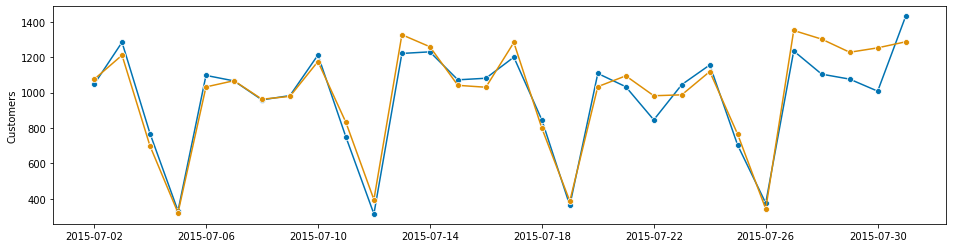

In [64]:
plot_series(y_test, es_preds_winner);

#### Score your models on the test set using MAE. 

See above cells

#### How did your best Holt-Winters model perform?

Better than our baseline seasonal model

## SARIMA
#### Make a SARIMA model. 
Use statsmodels, pmdarima, or sktime. 

Advice: don't try 364 for a seasonal period. Stick with 7. 364 hangs or performs poorly. If using sktime or pmdarima, you might be able to make a better model by manually adjusting the hyperparameters after automatically hyperparameter searching. The ARIMA class from sktime will let you adjust hyperparameters.

In [68]:
sarima_model = AutoARIMA(sp=7, trace=True)
sarima_model.fit(y_train)
sarima_preds = sarima_model.predict(y_test.index)
mean_absolute_error(y_test, sarima_preds)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13313.779, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=12667.484, Time=1.22 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13005.414, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=15064.963, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=13315.246, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=12865.721, Time=3.52 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13016.210, Time=2.09 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=13005.881, Time=0.77 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=12665.893, Time=0.99 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=12598.292, Time=4.07 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=12952.725, Time=2.29 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   :

131.29112252754538

#### Plot the test set predictions vs. actuals.

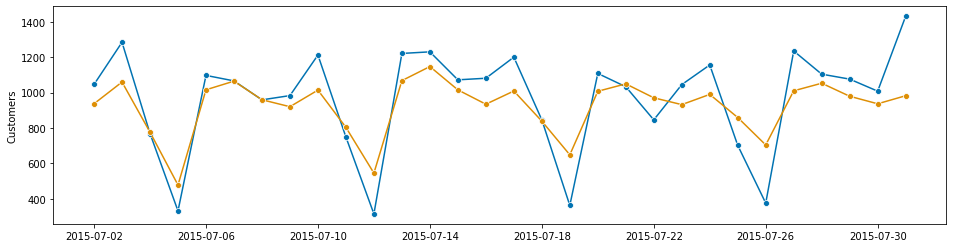

In [69]:
plot_series(y_test, sarima_preds);

#### Score your model on the test set using MAE. 

In [70]:
mean_absolute_error(y_test, sarima_preds)

131.29112252754538

#### How did that model do?

Considerably worse than our baseline and HW

---
## ⭐️ Bonus: SARIMAX

It is possible to create a model that beats the seasonal baseline by including StateHoliday and Promo as exogenous variables.


#### Bonus, not required: Make a SARIMAX model that uses *StateHoliday* and *Promo* for X. Use statsmodels, pmdarima, or sktime. 

You'll need to read in the data, clean it a bit, set up X and y, and train-test-split. I suggest making StateHoliday binary. For SARIMA, 364 likely won't work for seasonal periods, so keep it 7.

#### Plot the test set predictions vs. actuals.

#### Score your models on the test set using MAE. 

#### Which model performs best?